In [1]:
# Install packages only in a fresh session
if(!("keras" %in% rownames(installed.packages()))){
    install.packages("keras")
    install.packages("purrr")
    install.packages("patchwork")
    install.packages("tidyverse")
}

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘config’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library(keras)
library(purrr)
library(scales)
library(patchwork)
library(tidyverse)

# Set seed for reproducibility
tensorflow::tf$random$set_seed(42)

# Disable scientific notation of numbers
options(scipen = 999)

# Plot output size
options(repr.plot.width = 15, repr.plot.height = 12)

# Set custom theme as default
theme_crypto <- function() {
  theme_minimal() %+replace%
    theme(axis.text = element_text(size = 15),
          plot.title = element_text(size = 25, 
                       hjust = 0,
                       margin = margin(10, 0, 15, 0)),
          axis.title = element_text(size = 15),
          strip.text = element_text(size = 15),
          legend.text = element_text(size = 15),
          legend.title = element_text(size = 15),
          legend.key.size = unit(3, "line"),
          plot.caption = element_text(size = 15, hjust = 0),
          plot.subtitle = element_text(size = 15, hjust = 0))
}

theme_set(theme_crypto())


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ dplyr   1.0.4
✔ tibble  3.0.6     ✔ stringr 1.4.0
✔ tidyr   1.1.2     ✔ forcats 0.5.1
✔ readr   1.4.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ scales::discard()   masks purrr::discard()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()



In [31]:
# Functions for mapping
min_max_normalize <- function(x, original) {
  (x - min(original, na.rm = TRUE)) /
    (max(original, na.rm = TRUE) -
       min(original, na.rm = TRUE))
}

min_max_denormalize <- function(x, original) {
  rescale(x, to = c(min(original), max(original)))
}

normalize_multiple <- function(feature, .x){
  feature %>%
      mutate(!!colnames(.)[1] := 
              min_max_normalize(test_nonscaled %>% pull(.x),
                                train_scaling_columns %>% pull(.x)))
}

In [4]:
df <- read_csv("crypto-markets.csv")


── Column specification ────────────────────────────────────────────────────────
cols(
  slug = col_character(),
  symbol = col_character(),
  name = col_character(),
  date = col_date(format = ""),
  ranknow = col_double(),
  open = col_double(),
  high = col_double(),
  low = col_double(),
  close = col_double(),
  volume = col_double(),
  market = col_double(),
  close_ratio = col_double(),
  spread = col_double()
)




In [27]:
train_size <- 1000 + 1
test_size <- 200 + 1

# Hyperparameters

# Number of lagged features
n_lag <- 20

batch_size <- 64
epochs <- 100

In [6]:
# Get a specified amount of rows and select columns
model_data <- df %>%
  filter(name == "Bitcoin") %>% 
  slice((nrow(.) - (train_size + test_size) + 1 - n_lag):I(nrow(.))) %>%
  select(date, 
         bitcoin = close, 
         open, high, low, volume, market, close_ratio, spread) %>%
  # Return calculation can be done in-sample
  mutate_at(vars(open, high, low, bitcoin, volume, market, spread), 
            ~.x / lag(.x) - 1) %>%
  na.omit()

In [7]:
# Create lags for full dataset
model_features_lagged <- map(1:n_lag,
                             ~model_data %>% 
                                 mutate_if(is.numeric, 
                                           function(x) lag(x, .x)) %>% 
                                 # Keep date column as is
                                 setNames(c("date", 
                                            paste0(colnames(.)[-1], 
                                                   "_", 
                                                   .x)))) %>%
    reduce(full_join) %>%
    suppressMessages() %>%
    na.omit() %>%
    # Replace possible infinite values
    mutate_if(is.numeric, ~replace(.x, is.infinite(.x), 0))# %>%
    # FIXME
    #select(-open_1, -high_1, -low_1, -close_ratio_1)

# Target
model_target <- model_data %>%
    inner_join(model_features_lagged %>%
                  select(date)) %>%
    arrange(date) %>%
    select(date, bitcoin) %>%
    na.omit()

Joining, by = "date"



In [32]:
model_features_lagged

date,bitcoin_1,open_1,high_1,low_1,volume_1,market_1,close_ratio_1,spread_1,bitcoin_2,⋯,close_ratio_19,spread_19,bitcoin_20,open_20,high_20,low_20,volume_20,market_20,close_ratio_20,spread_20
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2015-08-17,-0.01162301663,-0.01378375325,-0.0158623017,-0.0163030999,0.538059427,-0.0114048243,0.2722,0.005586592,-0.01554501656,⋯,0.1406,0.783281734,0.002758668,0.003382996,-0.0037612923,0.0207688294,-0.167965481,0.002971025,0.3127,-0.687015504
2015-08-18,-0.00205021082,-0.01290716768,-0.0073540619,0.0003112356,-0.272540970,-0.0018012529,0.2537,-0.372222222,-0.01162301663,⋯,0.3230,-0.381944444,-0.016438542,0.002894800,-0.0071127591,-0.0158135096,-0.030683283,-0.016169600,0.1406,0.783281734
2015-08-19,-0.18179703853,-0.00216642810,-0.0096733331,-0.1790603609,0.949643582,-0.1815894297,0.0000,12.837758112,-0.00205021082,⋯,0.3489,0.859550562,-0.006457405,-0.018269492,-0.0149724995,-0.0076528845,-0.123083907,-0.006219985,0.3230,-0.381944444
2015-08-20,0.07390562820,-0.12507269414,-0.0797705337,0.0553818457,0.444205072,0.0742201344,0.2671,-0.687913025,-0.18179703853,⋯,0.5117,0.030211480,-0.010670096,-0.004842615,-0.0040326750,-0.0147607914,0.092129711,-0.010418380,0.3489,0.859550562
2015-08-21,0.03824775013,0.00545043648,-0.0001684849,0.0185393006,-0.469764676,0.0384976492,0.8071,-0.284836066,0.07390562820,⋯,0.9236,-0.193548387,-0.010714913,-0.010462287,-0.0139465670,-0.0149819367,-0.196118346,-0.010449459,0.5117,0.030211480
2015-08-22,-0.01181219460,0.03724107536,-0.0039600623,0.0212428383,-0.281989156,-0.0115356967,0.1805,-0.550143266,0.03824775013,⋯,0.1908,-0.047272727,0.003586648,-0.014893393,-0.0066683045,-0.0020855057,-0.067007107,0.003861211,0.9236,-0.193548387
2015-08-23,-0.00937352195,-0.01142978543,-0.0062174851,-0.0389262904,0.001385185,-0.0091015420,0.6272,1.602972399,-0.01181219460,⋯,0.8906,-0.145038168,-0.004883054,0.008415047,0.0086209942,0.0097286780,0.211706222,-0.004635810,0.1908,-0.047272727
2015-08-24,-0.00963583489,-0.00979970773,-0.0095760981,0.0129321958,-0.206813784,-0.0094100948,0.3633,-0.418433931,-0.00937352195,⋯,0.0973,-0.104910714,0.014187676,-0.005586790,0.0008407188,0.0035684973,0.020238334,0.014428135,0.8906,-0.145038168
2015-08-25,-0.07748608494,-0.00985328588,-0.0196381763,-0.0671158791,2.217362250,-0.0772156964,0.0028,1.482468443,-0.00963583489,⋯,0.0513,-0.124688279,-0.011710259,0.012872026,-0.0007350110,0.0009245102,-0.081278214,-0.011469078,0.0973,-0.104910714


In [33]:
model_features_lagged %>%
  select(-date) %>%
  mutate(bitcoin = model_target %>% select(bitcoin)) %>%
  cor(use = "pairwise.complete.obs") %>%
  as.data.frame() %>%
  select(bitcoin, everything()) %>%
  arrange(-abs(bitcoin))

,bitcoin,bitcoin_1,open_1,high_1,low_1,volume_1,market_1,close_ratio_1,spread_1,bitcoin_2,⋯,close_ratio_19,spread_19,bitcoin_20,open_20,high_20,low_20,volume_20,market_20,close_ratio_20,spread_20
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bitcoin,1.00000000,0.014473903,0.002855376,0.0082979897,0.009670472,0.048490793,0.014501497,0.0508139890,0.0232122765,0.000110589,⋯,0.020637363,-0.04368434245,0.0660369493,-0.0496354625,0.030155641,0.036107963,-0.004998514,0.0660682677,-0.003299962,0.03731719140
low_19,0.09361104,0.027094469,0.006328360,0.0153288142,0.005119416,0.053432892,0.027106805,0.0542310086,0.0083581137,0.005539889,⋯,0.259887854,-0.36204931889,0.4881563147,-0.0641543536,0.239953047,0.084672649,0.161373938,0.4881527865,0.449078927,0.12836526558
high_5,0.09220671,0.034130005,0.003150293,0.0160076181,0.068347203,-0.028390763,0.034151981,0.0330528265,-0.0272736973,0.003447381,⋯,0.049932417,-0.01782538625,0.0209979913,-0.0231605578,-0.033518623,0.011816713,-0.000205941,0.0210230269,0.025903630,-0.00351178952
low_6,0.06726950,0.029072411,0.007387431,0.0100742226,0.006874776,0.011722986,0.029099591,0.0462337292,-0.0147690718,0.007062834,⋯,0.006392669,0.00114990564,-0.0161363563,-0.0197261057,-0.018860606,0.003265456,-0.033252327,-0.0160735573,0.007641406,0.01354279628
open_19,0.06666818,0.052487232,0.041436390,0.0557256583,0.070567652,-0.014604655,0.052510176,0.0364923990,-0.0069485475,0.043632371,⋯,-0.073498919,0.00007151989,0.9951662104,0.0171154259,0.585852965,0.593115257,0.054871504,0.9951572144,0.664354039,-0.05529199880
market_20,0.06606827,0.054859286,0.037587602,0.0549664203,0.069904102,-0.015800359,0.054885538,0.0376450488,-0.0084750193,0.040183989,⋯,-0.071343273,0.00026953008,0.9999981283,0.0165331424,0.583165145,0.603038912,0.054729646,1.0000000000,0.660133275,-0.06592187721
bitcoin_20,0.06603695,0.054897288,0.037505618,0.0549402773,0.069858318,-0.015816440,0.054921180,0.0376657951,-0.0084813487,0.040102314,⋯,-0.071331832,0.00024985637,1.0000000000,0.0165455690,0.583153506,0.603037814,0.054648626,0.9999981283,0.660141375,-0.06595365680
spread_6,-0.06153402,-0.002155036,0.011183052,0.0210699101,-0.003627118,0.020782024,-0.002201997,-0.0053700133,0.0019713719,0.012192959,⋯,-0.057321791,0.04582518510,0.0415603566,0.0213605169,0.049990385,0.017646656,0.032781926,0.0415597869,0.046671646,0.01397485375
open_9,0.05953544,-0.004937897,0.009997607,-0.0016191471,-0.024768043,0.005880489,-0.004956304,0.0115443320,0.0087135897,0.011432545,⋯,-0.019155386,-0.00383044807,0.0486177474,0.0107349268,0.018459437,0.019369681,0.009746769,0.0486287927,0.032445640,0.01768134068


In [9]:
# Split features into training and test sets and min-max scale
train_scaling_columns <- model_features_lagged %>%
    slice(1:train_size) %>%
    select(-date)

train_scaled <- model_features_lagged %>%
    slice(1:train_size) %>%
    mutate_if(is.numeric, ~min_max_normalize(.x, .x)) %>%
    na.omit()

test_nonscaled <- model_features_lagged %>%
    slice((train_size + 1):(train_size + test_size)) %>%
    select(-date)

test_scaled <- map(1:ncol(test_nonscaled),
                   ~test_nonscaled %>%
                       select(.x) %>%
                       normalize_multiple(.x)) %>% 
    reduce(bind_cols)

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(.x)` instead of `.x` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



In [10]:
# Make lagged variables and put the values to matching positions
train_x <- train_scaled %>%
  select(-date) %>%
  as.matrix()

train_y <- model_target %>% 
  inner_join(train_scaled %>%
                select(date)) %>%
  pull(bitcoin)

test_x <- test_scaled %>%
  as.matrix()

test_y <- model_target %>% 
  anti_join(train_scaled %>%
                select(date)) %>%
  pull(bitcoin)

Joining, by = "date"

Joining, by = "date"



In [11]:
# Set the dimensions as required by TensorFlow
dim(train_x) <- c(nrow(train_x), ncol(train_x), 1)
dim(test_x) <- c(nrow(test_x), ncol(test_x), 1)

In [12]:
# First price and last cumulative return of the training set
first_value <- df %>%
  filter(name == "Bitcoin") %>% 
  slice((nrow(.) - (train_size + test_size) + 1 - n_lag):I(nrow(.))) %>%
  inner_join(model_target %>%
                select(date)) %>%
  pull(close) %>%
  first()
last_value <- last(cumprod(train_y + 1))

Joining, by = "date"



In [13]:
model_test <- keras_model_sequential()
  
model_test %>%
    layer_lstm(units = 20, 
               activation = "tanh",
               recurrent_activation = "sigmoid",
               recurrent_dropout = 0,
               dropout = 0.2,
               unroll = FALSE,
               use_bias = TRUE) %>% 
    layer_dense(units = 1)

model_test %>%
    compile(loss = "mse", 
            optimizer = "adam", 
            metrics = c("mae"))

tic <- Sys.time()
history_test <- model_test %>% fit(x = train_x,
                                   y = train_y,
                                   batch_size = batch_size,
                                   epochs = epochs,
                                   callbacks = callback_tensorboard("logs/l"),
                                   verbose = 1,
                                   validation_split = 0.2)
(toc <- Sys.time() - tic)

Time difference of 22.15097 secs

In [14]:
model_test

Model
Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
lstm (LSTM)                         (None, 20)                      1760        
________________________________________________________________________________
dense (Dense)                       (None, 1)                       21          
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
________________________________________________________________________________



`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



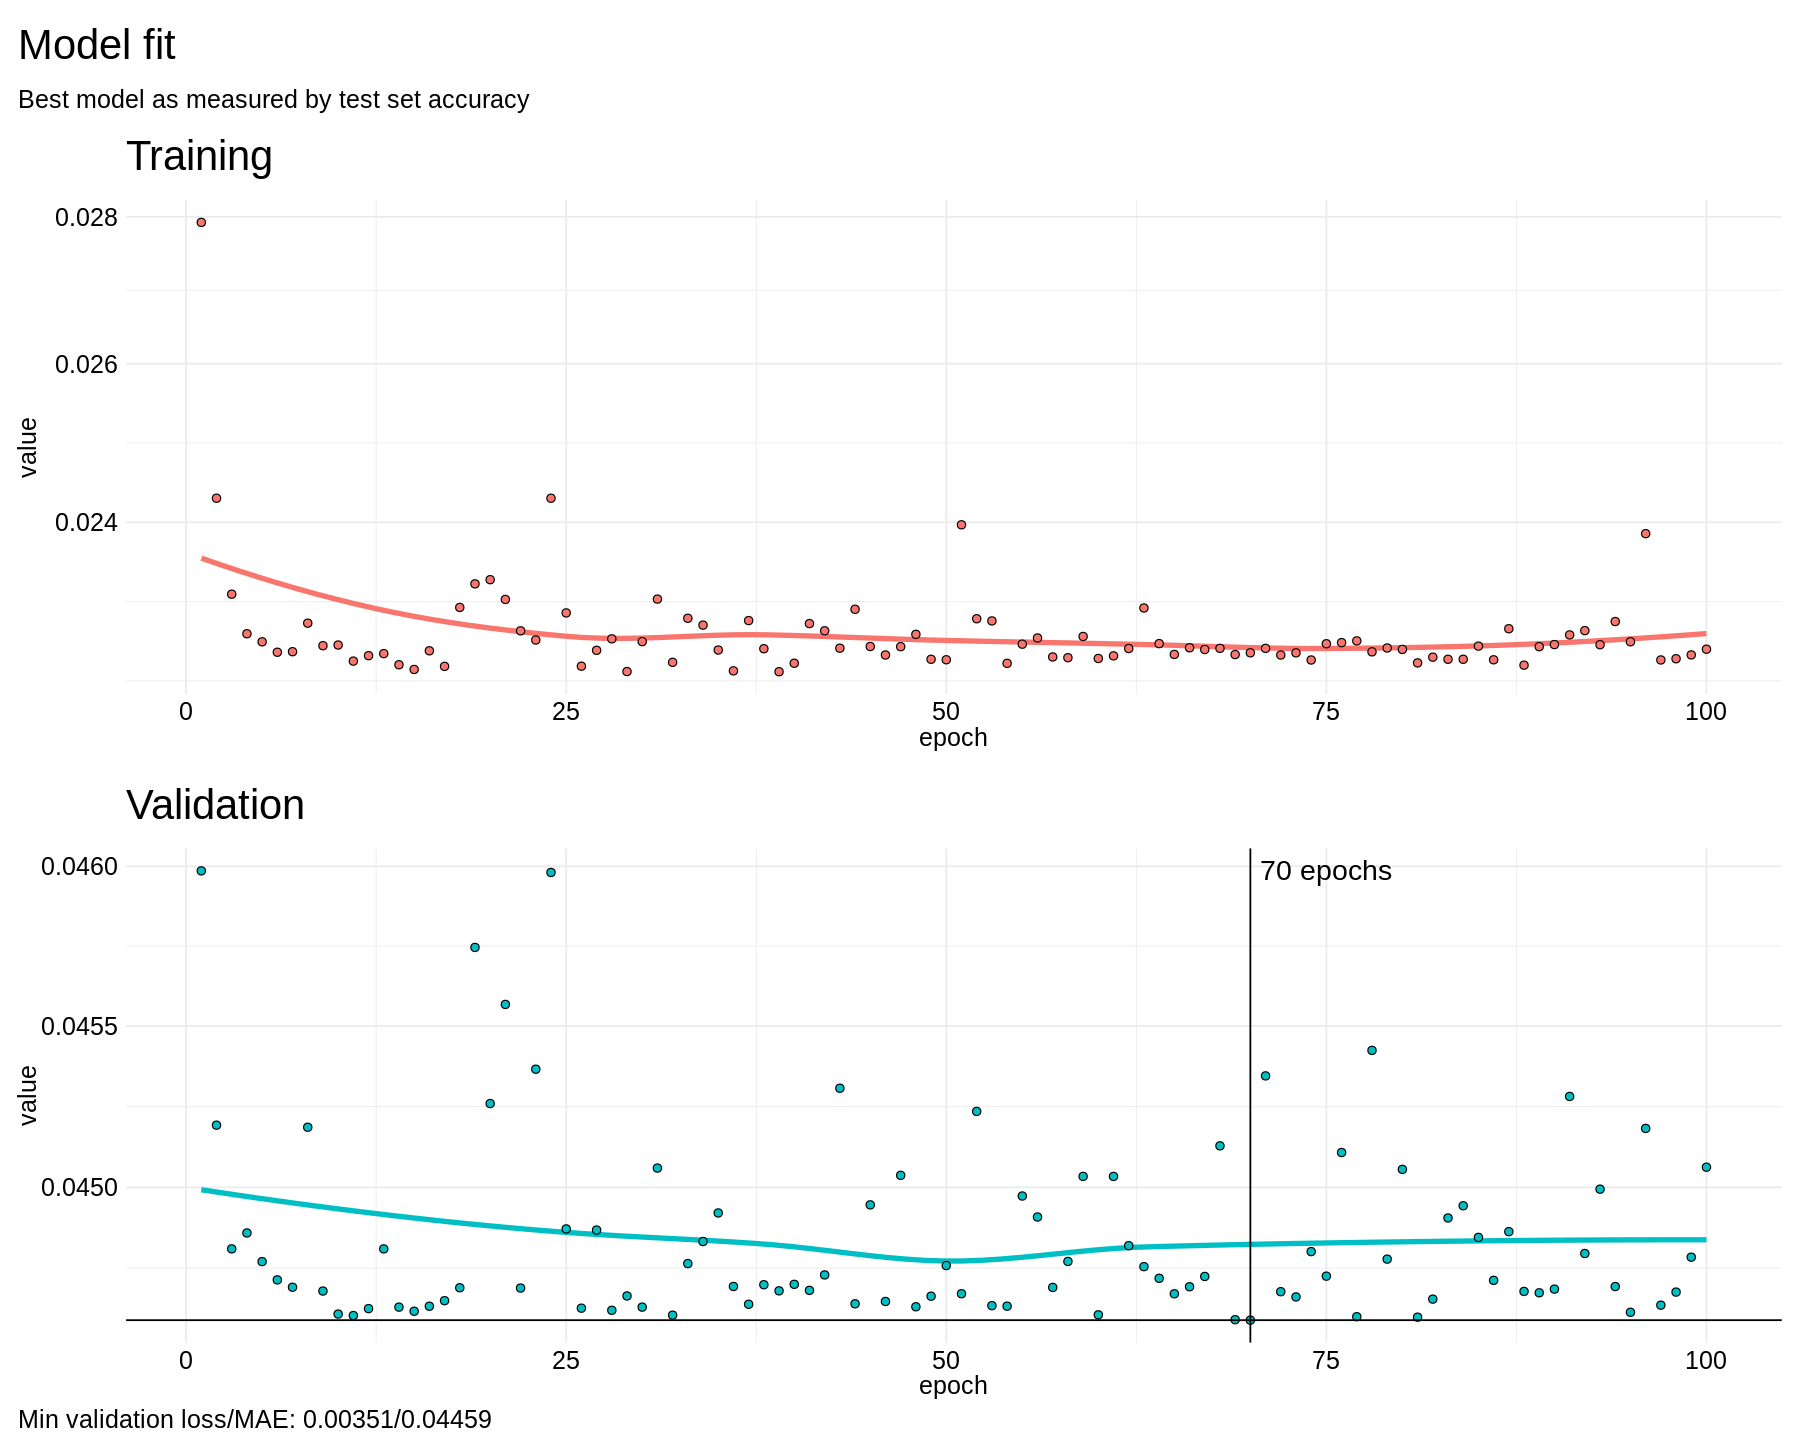

In [15]:
test_training_plot <- history_test %>% 
  as_tibble() %>%
  filter(metric == "mae", data == "training") %>%
  ggplot(aes(epoch, value)) +
  geom_smooth(color = "#F8766D", size = 1.5, se = FALSE) +
  geom_point(fill = "#F8766D", color = "black", shape = 21, size = 2) +
  ggtitle("Training") +
  scale_y_log10()

test_validation_plot <- history_test %>% 
  as_tibble() %>%
  filter(metric == "mae", data == "validation") %>%
  ggplot(aes(epoch, value)) +
  geom_smooth(color = "#00BFC4", size = 1.5, se = FALSE) +
  geom_point(fill = "#00BFC4", color = "black", shape = 21, size = 2) +
  geom_hline(yintercept = min(history_test$metrics$val_mae)) +
  geom_vline(xintercept = which(history_test$metrics$val_mae == 
                                  min(history_test$metrics$val_mae))) +
  annotate("text",
           size = 6,
           x = which(history_test$metrics$val_mae == 
                       min(history_test$metrics$val_mae)) + epochs / 20, 
           y = max(history_test$metrics$val_mae),
           label = paste(which(history_test$metrics$val_mae == 
                                 min(history_test$metrics$val_mae)),
                               "epochs")) +
  ggtitle("Validation") +
  scale_y_log10()

test_training_plot /
  test_validation_plot +
plot_annotation(
  title = "Model fit",
  subtitle = "Best model as measured by test set accuracy",
  caption = paste0(paste("Min validation loss/MAE:", 
              number_format(0.00001)(min(history_test$metrics$val_loss))),
              "/",
              number_format(0.00001)(min(history_test$metrics$val_mae))))

Warning message:
“Removed 1001 row(s) containing missing values (geom_path).”


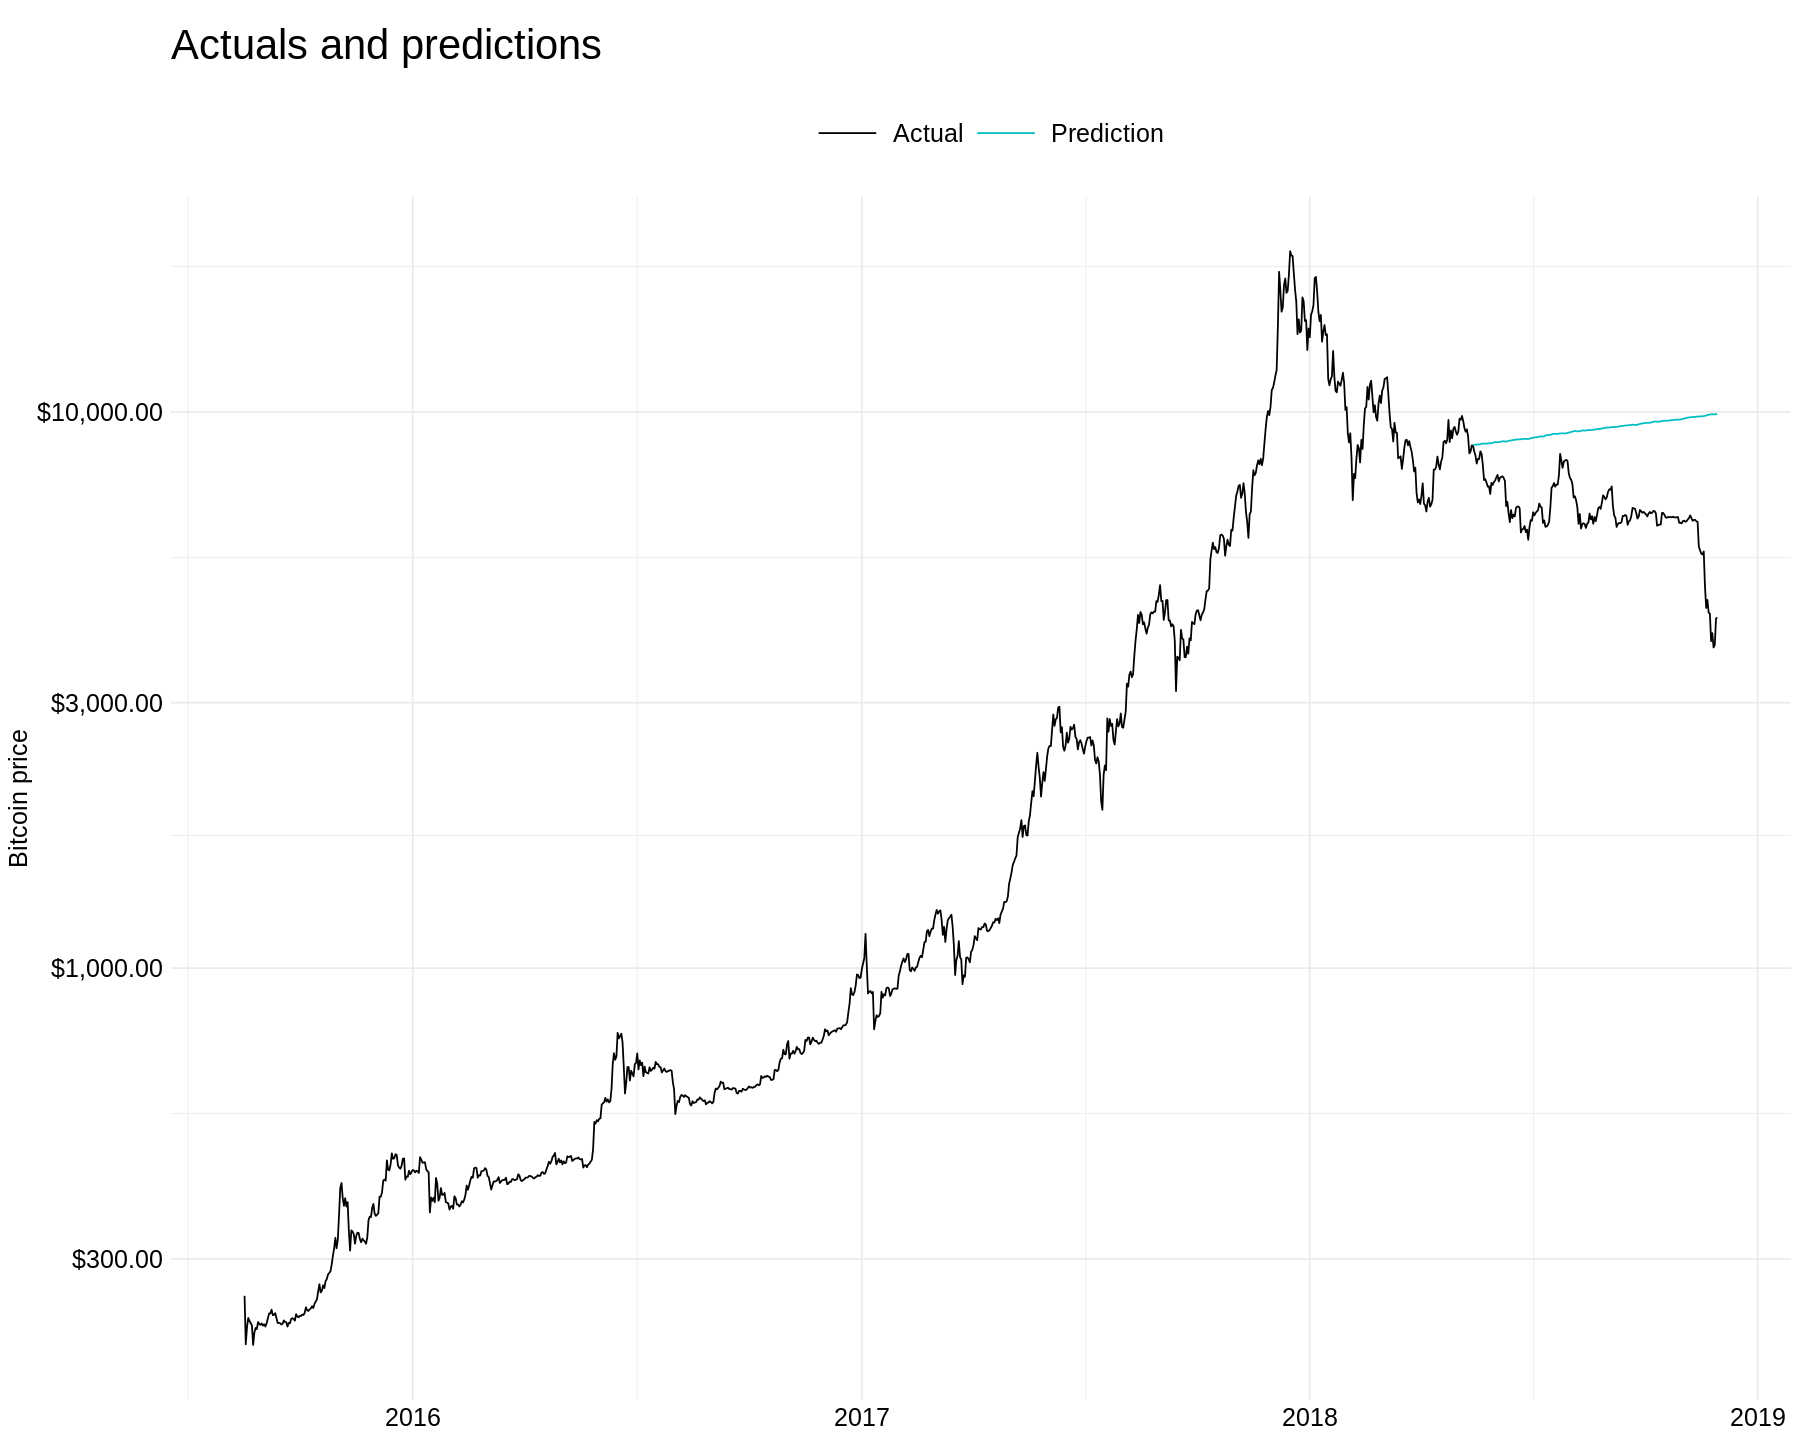

In [16]:
val_ts_plot <- tibble(date = model_features_lagged$date,
                      actual = first_value * c(cumprod(train_y + 1), 
                                 last_value * cumprod(test_y + 1)),
                      pred = first_value * last_value * 
                              c(rep(NA, length(train_y)), 
                               cumprod(predict(model_test, test_x) + 1)))

val_ts_plot %>% 
    rename(Actual = actual, Prediction = pred) %>%
    pivot_longer(Actual:Prediction) %>%
    ggplot(aes(date, value, color = name)) +
    geom_line() +
    scale_color_manual(values = c("black", "#00BFC4")) +
    scale_y_log10(labels = dollar) +
    ggtitle("Actuals and predictions") +
    xlab(NULL) +
    ylab("Bitcoin price") +
    theme(legend.position = "top",
          legend.title = element_blank())

In [24]:
test_cor_transformed <- cor(val_ts_plot$actual, val_ts_plot$pred, 
                            use = "pairwise.complete.obs")
test_rsq_transformed <- ifelse(test_cor_transformed > 0,
                               test_cor_transformed^2,
                               -(test_cor_transformed^2))

print(paste("R2:", number_format(0.001)(test_rsq_transformed)))

[1] "R2: -0.427"


In [18]:
results_transformed <- val_ts_plot %>%
    filter(!is.na(pred))

mean(abs(((results_transformed$actual) - results_transformed$pred) / 
             results_transformed$actual))


mean(abs((results_transformed$actual) - results_transformed$pred))



[1] 0.4324504

[1] 2656.087

In [25]:
model_test %>% 
  evaluate(test_x, test_y) %>%
  .[2] %>%
  number_format(0.0001)(.)

mae 
"0.0201"

In [20]:
test_cor <- cor(predict(model_test, test_x), test_y)
test_rsq <- ifelse(test_cor > 0,
                   test_cor^2,
                   -(test_cor^2))

print(paste("R2:", number_format(0.001)(test_rsq)))

[1] "R2: 0.018"


In [21]:
paste("Optimal number of epochs:",
      which(history_test$metrics$val_mae == 
                min(history_test$metrics$val_mae)))

[1] "Optimal number of epochs: 70"

# RESULT LOG

In [30]:
tribble(
    ~id, ~Layer1, ~U1, ~D1, ~Layer2, ~D2, ~U2, ~Layer3, ~U3, ~Epochs, ~n_lag, ~Batch, ~Activation, ~Function, ~Optimizer, ~lr, ~Optimal, ~Overfit, ~MAE,   ~R2,
    "s1",   "LSTM",  35,  NA,  NA,      NA,  NA,  NA,      NA,  1000,    20,     64,     "relu",      "mse",     "adam",     NA,  120,      TRUE,    0.0242, 0.008,
    "s2",   "GRU",   35,  NA,  NA,      NA,  NA,  NA,      NA,  25,      20,     64,     "relu",      "mse",     "adam",     NA,  120,      TRUE,    0.0221,-0.009,
    "s3",   "GRU",   35,  NA,  NA,      NA,  NA,  NA,      NA,  150,     20,     64,     "tanh",      "mse",     "adam",     NA,  18,       TRUE,    0.0201, 0.012,
    "s4",   "SRNN",  35,  NA,  NA,      NA,  NA,  NA,      NA,  150,     20,     64,     "relu",      "mse",     "adam",     NA,  23,       TRUE,    0.0213,-0.007,
    "s5",   "SRNN",  35,  NA,  "SRNN",  NA,  35,  NA,      NA,  150,     20,     64,     "relu",      "mse",     "adam",     NA,  1,        TRUE,    0.0204,-0.001,
    "s6",   "SRNN",  35,  NA,  "LSTM",  0.2, 35,  NA,      NA,  150,     20,     64,     "relu",      "mse",     "adam",     NA,  25,       TRUE,    0.0226,-0.014,
    "s7",   "SRNN",  35,  0.2, "LSTM",  0.2, 35,  NA,      NA,  150,     20,     64,     "relu",      "mse",     "adam",     NA,  24,       TRUE,    0.0325, 0.002,
    "s8",   "SRNN",  35,  NA,  "LSTM",  0.2, 35,  NA,      NA,  150,     20,     64,     "relu",      "mse",     "adam",     NA,  10,       TRUE,    0.0204,-0.006)

id,Layer1,U1,D1,Layer2,D2,U2,Layer3,U3,Epochs,n_lag,Batch,Activation,Function,Optimizer,lr,Optimal,Overfit,MAE,R2
<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<lgl>,<dbl>,<dbl>
s1,LSTM,35,NA,NA,NA,NA,NA,NA,1000,20,64,relu,mse,adam,NA,120,TRUE,0.0242,0.008
s2,GRU,35,NA,NA,NA,NA,NA,NA,25,20,64,relu,mse,adam,NA,120,TRUE,0.0221,-0.009
s3,GRU,35,NA,NA,NA,NA,NA,NA,150,20,64,tanh,mse,adam,NA,18,TRUE,0.0201,0.012
s4,SRNN,35,NA,NA,NA,NA,NA,NA,150,20,64,relu,mse,adam,NA,23,TRUE,0.0213,-0.007
s5,SRNN,35,NA,SRNN,NA,35,NA,NA,150,20,64,relu,mse,adam,NA,1,TRUE,0.0204,-0.001
s6,SRNN,35,NA,LSTM,0.2,35,NA,NA,150,20,64,relu,mse,adam,NA,25,TRUE,0.0226,-0.014
s7,SRNN,35,0.2,LSTM,0.2,35,NA,NA,150,20,64,relu,mse,adam,NA,24,TRUE,0.0325,0.002
s8,SRNN,35,NA,LSTM,0.2,35,NA,NA,150,20,64,relu,mse,adam,NA,10,TRUE,0.0204,-0.006


# **Write the results from the model in the code cell above**
---
**id**: Order number of the run

**Layer1-3**: names of layers used for each possible layer, LSTM/GRU/etc.

**U1-3**: how many units each layer had for all the existing layers

**Epochs**: total number of epochs ran

**N_lag**: number of lags used for the predictors

**Batch**: batch size used in training

**Activation**: the activation function, tanh/relu/sigmoid/etc.

**Function**: the loss function, mse/mean_absolute_error/etc.

**Optimizer**: adam/RMSProp/SGD/etc.

**lr**: learning rate, if one is not set automatically by adam

**Optimal**: the optimal number of epochs as shown in the cell above

**Overfit**: did the model overfit with the amount of epochs used, i.e. did the blue line in the first plot start going up after some point?

**MAE**: mae as provided in one of the cells above

**R2**: r-squared as provided in one of the cells above